# **Dependencies**

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

# **Data Preprocessing , DataSet and DataLoaders**

In [ ]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [ ]:
%env TOKENIZERS_PARALLELISM = false

# **Configuration**

In [54]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME = "gpt2"
BATCH_SIZE = 8
MAX_SEQ_LENGTH = 512
IMAGE_SIZE = 224

# Data Split Params
VALID_SIZE = 0.10
TEST_SIZE = 0.10
RANDOM_STATE = 42

In [55]:
def clean_text(text):
    if text is None:
        return ""
    # More comprehensive text cleaning for medical reports
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text

def create_data_manifest(xml_dir, img_dir):
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text = clean_text(findings_node.text if findings_node is not None else "")
            
            # Prepend custom section tokens
            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} {tokenizer.eos_token}"

            if not findings_text and not impression_text:
                continue
            
            image_nodes = root.findall(".//parentImage")
            image_paths = []
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if len(image_paths) > 0:
                manifest.append({
                    'image_paths': image_paths,  # << now a list
                    'report_text': full_report
                })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest



In [56]:
class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']  # This is now a list

        # Process all images for this report
        image_tensors = []
        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image)
            image_tensors.append(image_tensor)

        # Process text
        tokenized_report = self.tokenizer(
            report_text,
            truncation=True,
            max_length=512
        )
        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "images": image_tensors,          # <--- list of tensors
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_paths": image_paths        # <--- list of strings
        }


In [57]:
def custom_collate_fn(batch):
    # images: list of lists of tensors (each inner list is an example's images)
    image_lists = [item['images'] for item in batch]  # shape: (batch_size, num_views, C, H, W)
    image_paths_lists = [item['image_paths'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list = [item['labels'] for item in batch]

    # Pad image lists per batch; if using a SetTransformer fusion, you can stack as-is or pad to max view count within the batch
    max_views = max(len(images) for images in image_lists)
    batch_images = []
    mask = []
    for images in image_lists:
        padded = images + [torch.zeros_like(images[0])] * (max_views - len(images))
        batch_images.append(torch.stack(padded))
        mask.append([1]*len(images) + [0]*(max_views - len(images)))   # Optionally keep a mask

    batch_images = torch.stack(batch_images)  # (batch, max_views, C, H, W)
    view_mask = torch.tensor(mask)            # (batch, max_views)

    # Pad text sequences
    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest',
        return_tensors='pt'
    )
    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids']

    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'images': batch_images,            # (B, max_views, C, H, W)
        'view_mask': view_mask,            # Mask for valid views per study
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels,
        'image_paths': image_paths_lists   # list of lists
    }


In [58]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token  # Keep this line for consistent padding

# **____________________________________Testing______________________________________**

In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import random
import cv2

IMAGE_SIZE = 224

# Albumentations pipeline (conservative, radiology-safe)
def build_augs():
    return A.Compose([
        # Spatial (very mild)
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.0, rotate_limit=5, 
                           border_mode=cv2.BORDER_REFLECT_101, p=0.4),
        # Photometric
        A.RandomGamma(gamma_limit=(90,110), p=0.5),  # ~0.9–1.1
        A.CLAHE(clip_limit=(1.5,2.0), tile_grid_size=(8,8), p=0.3),
        A.GaussianBlur(blur_limit=(3,3), p=0.2),
        A.GaussNoise(var_limit=(1.0,10.0), p=0.3),  # very mild
        # Illumination/vignetting via multiplicative brightness field
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.0, p=0.3),
        A.ImageCompression(quality_lower=85, quality_upper=95, p=0.15),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])


In [45]:
class IUXRayDatasetAug(IUXRayDataset):
    def __init__(self, manifest, tokenizer, train=True):
        super().__init__(manifest, tokenizer, None)
        self.train = train
        self.train_aug = build_augs()
        self.eval_aug = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']

        # Generate one RNG state per study to sync augs across views
        if self.train:
            seed = random.randint(0, 10_000_000)
        image_tensors = []
        for p in image_paths:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.train:
                # Set same seed so transform params are shared
                random.seed(seed)
                np.random.seed(seed)
                out = self.train_aug(image=img)
            else:
                out = self.eval_aug(image=img)
            image_tensors.append(out["image"])

        tokenized = self.tokenizer(
            report_text, truncation=True, max_length=512
        )
        input_ids = tokenized['input_ids']
        labels = input_ids.copy()

        return {
            "images": image_tensors,
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_paths": image_paths
        }


In [46]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import re
from collections import Counter

# Build per-study weights based on rare keyword presence in IMPRESSION
RARE_TERMS = [
    "pneumothorax","pleural effusion","consolidation","edema",
    "atelectasis","cardiomegaly","emphysema","fibrosis","nodule",
    "opacity","infiltrate","effusion","tube","line","device"
]
pattern = re.compile("|".join([re.escape(t) for t in RARE_TERMS]), re.IGNORECASE)

def compute_weights(manifest):
    weights = []
    for m in manifest:
        text = m["report_text"]
        hits = len(pattern.findall(text))
        # base weight
        w = 1.0
        # boost if rare findings present
        if hits >= 1:
            w *= 1.8
        if hits >= 2:
            w *= 2.2
        # optionally boost multi-view studies
        if len(m["image_paths"]) >= 2:
            w *= 1.1
        weights.append(w)
    return torch.DoubleTensor(weights)



# --- Create manifest for multi-view ---
full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)

# --- Data splits ---
train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)


train_weights = compute_weights(train_manifest)
sampler = WeightedRandomSampler(train_weights, num_samples=len(train_manifest), replacement=True)

train_dataset = IUXRayDatasetAug(train_manifest, tokenizer, train=True)
val_dataset = IUXRayDatasetAug(val_manifest, tokenizer, train=False)
test_dataset = IUXRayDatasetAug(test_manifest, tokenizer, train=False)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)


Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:08<00:00, 480.03it/s]
/tmp/ipykernel_156/1826406483.py:20: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(1.0,10.0), p=0.3),  # very mild
/tmp/ipykernel_156/1826406483.py:23: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=85, quality_upper=95, p=0.15),


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths'])
Image tensor shape:      torch.Size([8, 3, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 127])
Attention mask shape:    torch.Size([8, 127])
Labels tensor shape:     torch.Size([8, 127])
View mask shape:         tensor([[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0]])


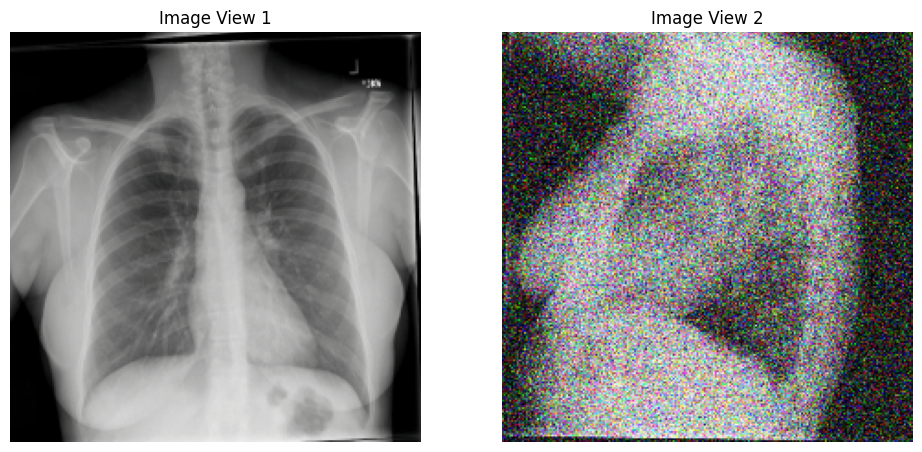


--- Sample Report from the same item (Decoded from Tensors) ---
 lungs are clear bilaterally. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality.  no acute cardiopulmonary abnormality. 
--------------------------------------------------


In [47]:
# --- Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"View mask shape:         {sample_batch.get('view_mask', 'Not present')}")  # If view_mask is in your collate_fn

# --- Visualization of all image views for a random report in the batch ---
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (num_views, C, H, W)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(6 * num_views, 6))
for i in range(num_views):
    # Optional: If using mask, skip padded images
    if 'view_mask' in sample_batch:
        if sample_batch['view_mask'][idx_to_show][i] == 0:
            continue  # padded image, skip

    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))

    plt.subplot(1, num_views, i + 1)
    plt.imshow(img_display)
    plt.title(f"Image View {i+1}")
    plt.axis('off')
plt.show()

# --- Decode the report text from input_ids for visualization ---
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)


# **_____________________________END_____________________________**

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:21<00:00, 181.01it/s]


Data successfully split:
Total samples: 3826
Training set:  3060 samples
Validation set: 383 samples
Test set:      383 samples

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---



You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths'])
Image tensor shape:      torch.Size([8, 3, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 89])
Attention mask shape:    torch.Size([8, 89])
Labels tensor shape:     torch.Size([8, 89])
View mask shape:         tensor([[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]])


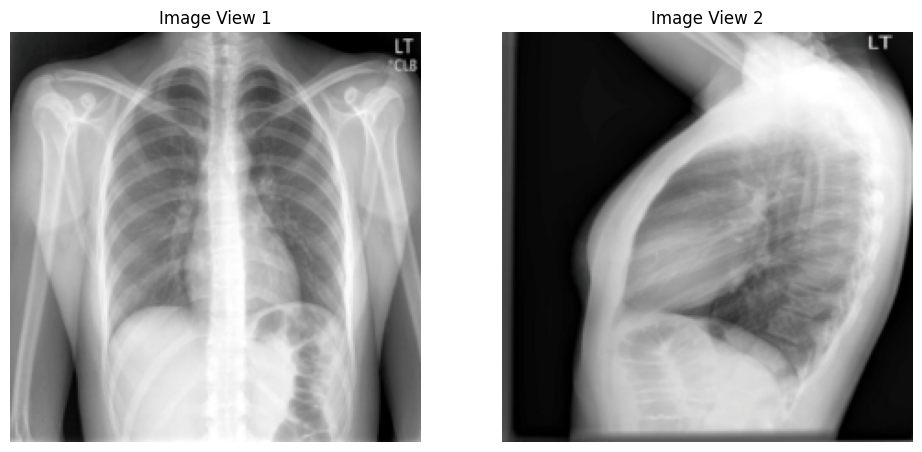


--- Sample Report from the same item (Decoded from Tensors) ---
   heart size, mediastinal silhouette and pulmonary vascularity are within normal limits. no focal consolidation, pleural effusion or pneumothorax. very mild right apex curvature and upper thoracic spine is nonspecific. 
--------------------------------------------------


In [59]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Image Transform ---
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Create manifest for multi-view ---
full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)

# --- Data splits ---
train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)

print(f"\nData successfully split:")
print(f"Total samples: {len(full_manifest)}")
print(f"Training set:  {len(train_manifest)} samples")
print(f"Validation set: {len(val_manifest)} samples")
print(f"Test set:      {len(test_manifest)} samples")

# --- Create Datasets and DataLoaders for multi-view ---
train_dataset = IUXRayDataset(train_manifest, tokenizer, image_transform)
val_dataset = IUXRayDataset(val_manifest, tokenizer, image_transform)
test_dataset = IUXRayDataset(test_manifest, tokenizer, image_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)

print("\nPyTorch DataLoaders are ready!")
print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"View mask shape:         {sample_batch.get('view_mask', 'Not present')}")  # If view_mask is in your collate_fn

# --- Visualization of all image views for a random report in the batch ---
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (num_views, C, H, W)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(6 * num_views, 6))
for i in range(num_views):
    # Optional: If using mask, skip padded images
    if 'view_mask' in sample_batch:
        if sample_batch['view_mask'][idx_to_show][i] == 0:
            continue  # padded image, skip

    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))

    plt.subplot(1, num_views, i + 1)
    plt.imshow(img_display)
    plt.title(f"Image View {i+1}")
    plt.axis('off')
plt.show()

# --- Decode the report text from input_ids for visualization ---
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)


# **MambaVision**

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

In [60]:
import torch
import torch.nn as nn
from transformers import AutoModel
import numpy as np

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        self.gradients = None
        self.activations = None

    def save_hook(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, grad):
        self.gradients = grad.detach()


    def forward(self, image_tensor):
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

    def register_hooks_for_gradcam(self, features):
        # Attach hooks to the last feature map, assumed to be the list's last element
        handle_fwd = features[-1].register_hook(self.save_gradient)
        self.activations = features[-1]
        return handle_fwd

    def gradcam(self, image_tensor, class_idx=None):
        self.model.zero_grad()
        image_tensor = image_tensor.to(self.device)

        # Forward pass, keep raw features
        pooled, features = self.model(image_tensor)
        self.activations = features[-1]  # pick the last stage

        # Register gradient hook
        hook = self.activations.register_hook(self.save_gradient)

        # Assume pooled.shape: (B, 640)
        if class_idx is None:
            class_idx = pooled.argmax(dim=1)
        # Compute score for the target class
        loss = pooled[:, class_idx].sum()
        loss.backward(retain_graph=True)

        # Compute weights (global average pooling over spatial dims)
        gradients = self.gradients
        pooled_grads = torch.mean(gradients, dim=[2, 3], keepdim=True)
        gradcam_map = (pooled_grads * self.activations).sum(dim=1, keepdim=True)
        gradcam_map = torch.nn.functional.relu(gradcam_map)
        gradcam_map = torch.nn.functional.interpolate(
            gradcam_map, size=image_tensor.shape[2:], mode='bilinear', align_corners=False
        )

        # Normalize between 0 and 1
        gradcam_map -= gradcam_map.min()
        gradcam_map /= (gradcam_map.max() + 1e-8)

        hook.remove()

        return gradcam_map.cpu().squeeze().detach().numpy()


In [ ]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load a batch ===
sample_batch = next(iter(train_loader))
images = sample_batch['images'].to('cuda')  # shape: (B, max_views, 3, 224, 224)

# === Forward pass (extract features for all views, all samples) ===
B, V, C, H, W = images.shape
images_flat = images.view(B * V, C, H, W)  # flatten for encoder: (B*V, 3, 224, 224)

with torch.no_grad():
    pooled_feats, stage_feats = encoder(images_flat)  # pooled_feats: (B*V, 640), stage_feats: list of (B*V, 640, 7, 7)

# --- To visualize for the idx-th item in batch, loop through its views ---
idx = 0  # select which batch sample to visualize

for view_idx in range(V):
    # Retrieve the current view's original image and feature map
    image_tensor = images[idx, view_idx].cpu()
    feature_map = stage_feats[3][idx * V + view_idx]  # select correct index in flattened batch

    # === Generate heatmap ===
    activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
    activation_map = cv2.resize(activation_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # === Unnormalize image ===
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (image_tensor * std) + mean
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
    img = np.uint8(255 * img)

    # === Overlay heatmap ===
    overlay = np.uint8(0.5 * img + 0.5 * heatmap)

    # === Display ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Heatmap (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (View {view_idx+1})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# **Projection layer**

In [61]:
import torch
import torch.nn as nn

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768, hidden_dim=1024, dropout=0.1):
        super().__init__()
        
        self.vision_dim = vision_dim
        self.gpt2_emb_dim = gpt2_emb_dim

        self.linear1 = nn.Linear(vision_dim, hidden_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, gpt2_emb_dim)
        self.norm = nn.LayerNorm(gpt2_emb_dim)

        # Use residual path only if input and output dim match
        self.use_residual = (vision_dim == gpt2_emb_dim)
        if self.use_residual:
            self.residual_proj = nn.Identity()
        else:
            self.residual_proj = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        x = self.linear1(vision_feat)        # (B, hidden_dim)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)                  # (B, gpt2_emb_dim)

        # Residual + LayerNorm
        x = self.norm(x + self.residual_proj(vision_feat))  # (B, gpt2_emb_dim)
        return x


# **CustomGPT2**

In [62]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [89]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out,qk_t

In [64]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [98]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out,return_attn=False):
        x = x + self.attn(self.ln_1(x))
        cross_out, cross_weights = self.cross_attn(self.ln_2(x), enc_out, enc_out)  # << get weights
        x = x + cross_out
        x = x + self.mlp(self.ln_3(x))
        if return_attn:
            return x, cross_weights  # (B,H,T,S)
        return x

# **Main GPT2 Block**

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        
    def resize_token_embeddings(self, new_num_tokens):
        """
        Resize token embeddings and lm_head when vocabulary size changes (e.g., after adding special tokens).
        """
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
    
        if new_num_tokens == old_num_tokens:
            return self.wte
    
        # 1. New embedding layer
        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings
    
        # 2. New lm_head layer
        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head
    
        return self.wte


    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None,return_attentions=False,capture_last_step_only=True):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        cross_attn_per_layer = [] if return_attentions else None

        for block in self.blocks:
            if return_attentions:
                x, cross_w = block(x, encoder_hidden_states, return_attn=True)
                # Optionally only keep the attentions for the last time step token
                if capture_last_step_only:
                    # cross_w: (B,H,T,S) -> take T-1 (current step) if needed, else keep full
                    cross_attn_per_layer.append(cross_w[:, :, -1:, :])  # (B,H,1,S)
                else:
                    cross_attn_per_layer.append(cross_w)               # (B,H,T,S)
            else:
                x = block(x, encoder_hidden_states, return_attn=False)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100
            )
            if return_attentions:
                return SimpleNamespace(loss=loss, logits=logits, cross_attentions=cross_attn_per_layer)
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            if return_attentions:
                return SimpleNamespace(logits=logits, cross_attentions=cross_attn_per_layer)
            return SimpleNamespace(logits=logits)


# **EfficientMultiViewTransformerFusion**

In [67]:
import torch
import torch.nn as nn

class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1, max_views=10):
        super().__init__()
        self.vision_dim = vision_dim
        self.max_views = max_views

        # Positional encodings: learnable embeddings for each view position
        self.pos_embed = nn.Parameter(torch.zeros(1, max_views, vision_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)  # Initialize with small values

        # Transformer encoding layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Attention-based pooling (query vector learned to pool view features)
        self.pool_query = nn.Parameter(torch.randn(1, 1, vision_dim))
        self.pool_attention = nn.MultiheadAttention(
            embed_dim=vision_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, feats, view_mask=None):
        """
        Args:
            feats: (batch, num_views, vision_dim) tensor
            view_mask: (batch, num_views) tensor, 1 for valid view, 0 for padding

        Returns:
            pooled: (batch, vision_dim) tensor
        """
        B, V, D = feats.shape
        assert V <= self.max_views, f"Number of views ({V}) cannot exceed max_views ({self.max_views})"

        # Add positional embeddings (slice or view position awareness)
        # If V < max_views, use only the first V positional embeddings
        pos_emb = self.pos_embed[:, :V, :]  # (1, V, D)
        feats = feats + pos_emb

        # Prepare mask for transformer: True means padding (ignore)
        key_padding_mask = None
        if view_mask is not None:
            key_padding_mask = (view_mask == 0)  # (B, V) bool tensor

        # Encode with transformer
        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # (B, V, D)

        # Attention pooling with learned query to aggregate views
        # Query shape: (B, 1, D)
        query = self.pool_query.expand(B, -1, -1)  # expand along batch

        # Attention mask for pooling (key_padding_mask)
        # MultiheadAttention expects attn_mask with shape (target_len, source_len), but padding mask is preferred here
        # Use key_padding_mask as is
        attn_output, attn_weights = self.pool_attention(
            query=query,
            key=encoded,
            value=encoded,
            key_padding_mask=key_padding_mask
        )  # attn_output: (B, 1, D)

        pooled = attn_output.squeeze(1)  # (B, D) final pooled fused feature

        return pooled


# **Main Block**

In [100]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2,fusion_module):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block
        self.fusion_module = fusion_module
    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None,return_attentions=False,capture_last_step_only=True ):
        # images: (batch, max_views, C, H, W)
        B, max_views, C, H, W = images.shape
        images_flat = images.view(B * max_views, C, H, W)

        # 1. Extract visual features for all images in the batch
        pooled_feats_flat, _ = self.vision_encoder(images_flat)    # (B*max_views, vision_dim)
        vision_dim = pooled_feats_flat.shape[-1]
        pooled_feats = pooled_feats_flat.view(B, max_views, vision_dim)  # (B, max_views, vision_dim)
        # 2. Fuse features for each study
        fused_feats = self.fusion_module(pooled_feats, view_mask=view_mask)  # (B, vision_dim)
        # 3. Project
        visual_emb = self.proj_layer(fused_feats).unsqueeze(1)  # (B, 1, gpt2_emb_dim)
        # 4. Pass to decoder
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels,
            return_attentions=return_attentions,                 
            capture_last_step_only=capture_last_step_only  
        )
        return outputs

    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class,fusion_module):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))
        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)
        

        return cls(vision_encoder, proj_layer, custom_gpt2,fusion_module)


# **Trainer Class**

In [94]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: your tokenizer (must have .bos_token_id and .eos_token_id)
        train_config: SimpleNamespace/args for training params (epochs, device, lr, batch_size, etc.)
        dls: tuple of (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        total_steps = len(self.train_dl)

        self.scaler = torch.cuda.amp.GradScaler()
        self.optim = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.vl_model.parameters()),
            lr=train_config.lr / 25.
        )
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=train_config.lr,
            epochs=train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None
    import matplotlib.pyplot as plt

    @torch.no_grad()
    def visualize_cross_attention(self, num_batches=1, capture_last_step_only=True):
        self.vl_model.eval()
        batches = 0
        for batch in self.val_dl:
            images = batch['images'].to(self.device)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            out = self.vl_model(
                images=images,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                view_mask=view_mask,
                return_attentions=True,
                capture_last_step_only=capture_last_step_only
            )
            cross_list = out.cross_attentions  # list of length = n_layers

            # Example: visualize for the first sample in batch
            bidx = 0
            # For each layer, average over heads
            layer_maps = []
            for layer_idx, att in enumerate(cross_list):
                # att shape: (B,H,1,S) if capture_last_step_only else (B,H,T,S)
                if capture_last_step_only:
                    att_b = att[bidx]             # (H,1,S)
                    att_avg = att_b.mean(dim=0)   # (1,S)
                else:
                    att_b = att[bidx]             # (H,T,S)
                    att_avg = att_b.mean(dim=0)   # (T,S)
                layer_maps.append(att_avg.cpu().squeeze(0).numpy() if capture_last_step_only else att_avg.cpu().numpy())

            # Plot a simple overview: last layer attention
            last_map = layer_maps[-1]  # shape (S,) or (T,S)
            plt.figure(figsize=(6,4))
            if capture_last_step_only:
                plt.bar(range(last_map.shape[-1]), last_map)  # attention over source tokens
                plt.title("Last layer cross-attention (avg over heads) to visual tokens")
                plt.xlabel("Visual token index (src positions)")
                plt.ylabel("Attention weight")
            else:
                plt.imshow(last_map, aspect='auto', cmap='viridis')
                plt.colorbar()
                plt.title("Last layer cross-attention (avg heads): text tokens x visual tokens")
                plt.xlabel("Visual token index (src)")
                plt.ylabel("Text token index (tgt)")
            plt.tight_layout()
            plt.show()

            batches += 1
            if batches >= num_batches:
                break


    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.vl_model.state_dict()
        torch.save(sd, self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt')
        self.vl_model.load_state_dict(sd)
    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)


    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)
        for batch_idx, batch in enumerate(self.train_dl):
            images = batch['images'].to(self.device)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels,view_mask=view_mask)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs  # If forward returns just loss

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            self.sched.step()
            self.optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            del images, input_ids, labels, loss

        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f}")
        return train_pxp
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)
        for batch_idx, batch in enumerate(self.val_dl):
            images = batch['images'].to(self.device)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels,view_mask=view_mask)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs

            running_loss += loss.item()
            del images, input_ids, labels, loss

        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        for epoch in prog:
            # Stage-wise freezing/unfreezing
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')

            train_pxp=self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
            print(self.metrics.tail(1))

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
    def plot_loss_and_perplexity(self):
        """
        Plot Loss and Perplexity curves using the stored self.metrics DataFrame.
        """
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))
    
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()
    
        # Plot perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
    @staticmethod
    def clean_and_format_report(generated_report: str) -> str:
        # Replace tags with human-friendly section titles
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
    
        # Split into sections and keep only the first occurrence
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
    
        # Remove repeated lines within sections (Impression is most often repeated)
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
    
        # Nicely format the fields
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report
    @torch.no_grad()
   
    def robust_generate_radiology_report(
        self,
        image_input,             # file path, PIL.Image, list of paths, or list of PIL.Image
        max_tokens=120,
        temperature=1.0,
        top_k=None,
        top_p=None,
        beam_width=1,            # If >1, activates beam search decoding
        num_return_sequences=1,  # Number of candidate sequences to generate
        temperature_range=None,  # e.g., (0.7, 1.1), for random temp sampling if desired
        deterministic=False,
        show_image=False,
    ):
        """
        Generate structured radiology reports from multi-view images with controlled decoding.
    
        Decoding supports greedy, sampling with top-k/top-p, and beam search.
    
        Multiple candidates can be generated and ranked by likelihood.
    
        Report text is cleaned and formatted with section tokens replaced.
        """
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device
    
        model.eval()
    
        # Prepare list of images (multi-view)
        img_list = []
        if isinstance(image_input, list):
            for img in image_input:
                if isinstance(img, (str, bytes, os.PathLike)):
                    im = Image.open(img).convert('RGB')
                elif isinstance(img, Image.Image):
                    im = img.convert('RGB')
                else:
                    raise ValueError("Each item must be a file path or PIL.Image.")
                img_list.append(im)
        else:
            if isinstance(image_input, (str, bytes, os.PathLike)):
                img_list = [Image.open(image_input).convert('RGB')]
            elif isinstance(image_input, Image.Image):
                img_list = [image_input.convert('RGB')]
            else:
                raise ValueError("image_input should be a file path, PIL.Image, or a list thereof.")
    
        if show_image:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img)
                plt.title(f"Image View {i+1}")
                plt.axis('off')
            plt.show()
    
        # Preprocess images
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        imgs_pp = [transform(img) for img in img_list]
        imgs_pp = torch.stack(imgs_pp)  # (num_views, C, H, W)
        imgs_pp = imgs_pp.unsqueeze(0).to(device)  # (1, num_views, C, H, W)
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=device)
    
        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
    
        # Handle temperature range sampling
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)
    
        def generate_candidate():
            sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
            for _ in range(max_tokens):
                feats_flat, _ = model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
                vision_dim = feats_flat.shape[-1]
                feats = feats_flat.view(1, num_views, vision_dim)
                fused_feats = model.fusion_module(feats, view_mask)
                visual_emb = model.proj_layer(fused_feats).unsqueeze(1)
    
                out = model.gpt2(sequence, encoder_hidden_states=visual_emb).logits
                logits = out[:, -1, :] / temperature
    
                # Apply top-k and/or top-p filtering if specified
                filtered_logits = logits.clone()
                if top_k is not None:
                    top_k_val = min(top_k, logits.size(-1))
                    indices_to_remove = filtered_logits < torch.topk(filtered_logits, top_k_val)[0][..., -1, None]
                    filtered_logits[indices_to_remove] = -float('Inf')
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(filtered_logits, descending=True)
                    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    filtered_logits[0, indices_to_remove] = -float('Inf')
    
                probs = torch.softmax(filtered_logits, dim=-1)
                if deterministic:
                    next_token = torch.argmax(probs, dim=-1, keepdim=True)
                else:
                    next_token = torch.multinomial(probs, num_samples=1)
    
                sequence = torch.cat([sequence, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break
    
            return sequence
    
        if beam_width > 1:
            # Beam search decoding
            sequences = [(torch.tensor([[section_token_id]], device=device), 0.0)]  # (seq, score)
            for _ in range(max_tokens):
                all_candidates = []
                completed_sequences = []
                for seq, score in sequences:
                    feats_flat, _ = model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
                    vision_dim = feats_flat.shape[-1]
                    feats = feats_flat.view(1, num_views, vision_dim)
                    fused_feats = model.fusion_module(feats, view_mask)
                    visual_emb = model.proj_layer(fused_feats).unsqueeze(1)
    
                    out = model.gpt2(seq, encoder_hidden_states=visual_emb).logits
                    logits = out[:, -1, :] / temperature
                    log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)  # shape (vocab_size)
                    topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
    
                    for k in range(beam_width):
                        next_token = topk_indices[k].unsqueeze(0).unsqueeze(0)
                        candidate_seq = torch.cat([seq, next_token], dim=1)
                        candidate_score = score + topk_log_probs[k].item()
                        all_candidates.append((candidate_seq, candidate_score))
    
                # Select top-k best
                ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
                sequences = ordered[:beam_width]
    
                # If all sequences ended with eos, stop early
                if all(seq[0][0, -1].item() == tokenizer.eos_token_id for seq in sequences):
                    break
    
            # Pick the best sequence
            best_seq = sequences[0][0]
            sequence = best_seq
    
        else:
            # Generate candidates (either single or multiple)
            if num_return_sequences == 1:
                sequence = generate_candidate()
            else:
                candidates = []
                for _ in range(num_return_sequences):
                    candidates.append(generate_candidate())
    
                # Rank candidates by average log probability
                scored_candidates = []
                for seq in candidates:
                    with torch.no_grad():
                        feats_flat, _ = model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
                        vision_dim = feats_flat.shape[-1]
                        feats = feats_flat.view(1, num_views, vision_dim)
                        fused_feats = model.fusion_module(feats, view_mask)
                        visual_emb = model.proj_layer(fused_feats).unsqueeze(1)
                        logits_seq = model.gpt2(seq[:, :-1], encoder_hidden_states=visual_emb).logits
                        log_probs = torch.nn.functional.log_softmax(logits_seq, dim=-1)
    
                        # Sum log probs for actual tokens
                        token_log_probs = log_probs.gather(-1, seq[:, 1:].unsqueeze(-1)).squeeze(-1)
                        avg_log_prob = token_log_probs.mean().item()
                        scored_candidates.append((seq, avg_log_prob))
    
                # Pick highest scoring candidate
                scored_candidates.sort(key=lambda x: x[1], reverse=True)
                sequence = scored_candidates[0][0]
    
        # Decode and clean the report text
        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=False)
        final_report = self.clean_and_format_report(report)
    
        return final_report


In [70]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 10,
    freeze_epochs_gpt = 2,        # unfreeze GPT-2 at epoch 3 (0-based index)
    freeze_epochs_all = 3,        # unfreeze vision/proj at epoch 4
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),
    batch_size = 8,
)



In [101]:

# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,      
    num_layers=3,        
    num_heads=8,        
    dropout=0.1         
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM,
    fusion_module
).to(train_config.device)

# --- Trainer ---
# Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, val_loader)  # tuple of your dataloaders
)


/tmp/ipykernel_156/4164356190.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [72]:
trainer.fit()

  0%|          | 0/10 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 4.3887 | Perplexity: 80.5326


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 2.1320 | Perplexity: 8.4316
  train_loss train_perplexity  val_loss val_perplexity
0   4.388663        80.532646  2.131984        8.43158
Saving best model...


 10%|█         | 1/10 [01:31<13:40, 91.15s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Train Loss: 1.8842 | Perplexity: 6.5808


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Valid Loss: 1.7046 | Perplexity: 5.4991
  train_loss train_perplexity  val_loss val_perplexity
1   1.884161          6.58083  1.704582       5.499087
Saving best model...


 20%|██        | 2/10 [02:58<11:52, 89.11s/it]

Unfreezing GPT-2 decoder...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Train Loss: 1.5629 | Perplexity: 4.7724


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Valid Loss: 1.5440 | Perplexity: 4.6833
  train_loss train_perplexity  val_loss val_perplexity
2   1.562857         4.772437  1.544002       4.683295
Saving best model...


 30%|███       | 3/10 [04:26<10:18, 88.39s/it]

Unfreezing vision encoder and projection...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Train Loss: 1.3767 | Perplexity: 3.9620


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Valid Loss: 1.4774 | Perplexity: 4.3816
  train_loss train_perplexity  val_loss val_perplexity
3   1.376742         3.961971  1.477411       4.381587
Saving best model...


 40%|████      | 4/10 [05:53<08:46, 87.81s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Train Loss: 1.2025 | Perplexity: 3.3284


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Valid Loss: 1.3958 | Perplexity: 4.0383
  train_loss train_perplexity  val_loss val_perplexity
4   1.202499         3.328423  1.395824       4.038302
Saving best model...


 50%|█████     | 5/10 [07:20<07:18, 87.74s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Train Loss: 0.9848 | Perplexity: 2.6772


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Valid Loss: 1.3591 | Perplexity: 3.8927
  train_loss train_perplexity  val_loss val_perplexity
5    0.98479         2.677249  1.359101       3.892694
Saving best model...


 60%|██████    | 6/10 [08:48<05:50, 87.57s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Train Loss: 0.7457 | Perplexity: 2.1078


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Valid Loss: 1.3476 | Perplexity: 3.8482
  train_loss train_perplexity  val_loss val_perplexity
6   0.745662         2.107837  1.347617       3.848245
Saving best model...


 70%|███████   | 7/10 [10:15<04:22, 87.41s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Train Loss: 0.4993 | Perplexity: 1.6476


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Valid Loss: 1.3782 | Perplexity: 3.9676


 80%|████████  | 8/10 [11:40<02:53, 86.63s/it]

  train_loss train_perplexity  val_loss val_perplexity
7   0.499322         1.647603  1.378156       3.967579


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Train Loss: 0.3406 | Perplexity: 1.4058


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Valid Loss: 1.4092 | Perplexity: 4.0929


 90%|█████████ | 9/10 [13:04<01:25, 85.96s/it]

  train_loss train_perplexity  val_loss val_perplexity
8   0.340604         1.405796  1.409244       4.092861


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Train Loss: 0.2788 | Perplexity: 1.3216


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_156/692059715.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Valid Loss: 1.4209 | Perplexity: 4.1410


100%|██████████| 10/10 [14:29<00:00, 86.94s/it]

  train_loss train_perplexity  val_loss val_perplexity
9   0.278845         1.321603  1.420932        4.14098


{'best_perplexity': 3.8482446943614326, 'best_epoch': 6}

# **Loading Trained Model**

In [102]:
trainer.load_best_model()

In [ ]:
trainer.load_model_from_path("/kaggle/input/test-model-mambavision/vl_model-3.pt")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


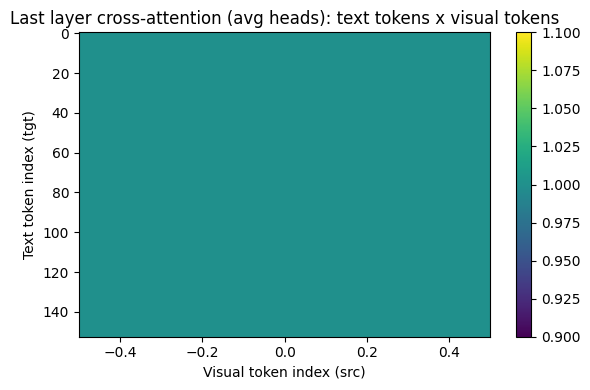

In [106]:
trainer.visualize_cross_attention(num_batches=1, capture_last_step_only=False)

# **Report Genearation**

In [86]:
report_beam = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1013_IM-0013-2001.png"],
    max_tokens=200,
    deterministic=True,     # Greedy inside each beam step (no sampling)
    beam_width=5,           # Beam search enabled
    top_k=None,             # Not used in deterministic + beam mode
    top_p=None,             # Not used in deterministic + beam mode
    num_return_sequences=1, # Not used in beam mode
    show_image=False        # Set True to visualize the input
)
print("Generated report (beam):\n", report_beam)


Generated report (beam):
 Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.


In [ ]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([train_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [ ]:
from torch.utils.data import ConcatDataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths_list = batch['image_paths']  # <- list of lists: one per sample

        for i in range(len(image_paths_list)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # --- Load all image views for this report ---
            pil_imgs = []
            for image_path in image_paths_list[i]:
                pil_img = Image.open(image_path).convert('RGB')
                pil_imgs.append(pil_img)
            # --- Generate report from all images for this study ---
            gen_report = trainer.robust_generate_radiology_report(
                pil_imgs,    # passing list of PIL images for multi-view support
                deterministic=True
            )
            
            
            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)
            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)


            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


In [87]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_imgs,
            max_tokens=200,
            deterministic=True,     # Greedy inside each beam step (no sampling)
            beam_width=5,           # Beam search enabled
            top_k=None,             # Not used in deterministic + beam mode
            top_p=None,             # Not used in deterministic + beam mode
            num_return_sequences=1, # Not used in beam mode
            show_image=False        # Set True to visualize the input
            
        )

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


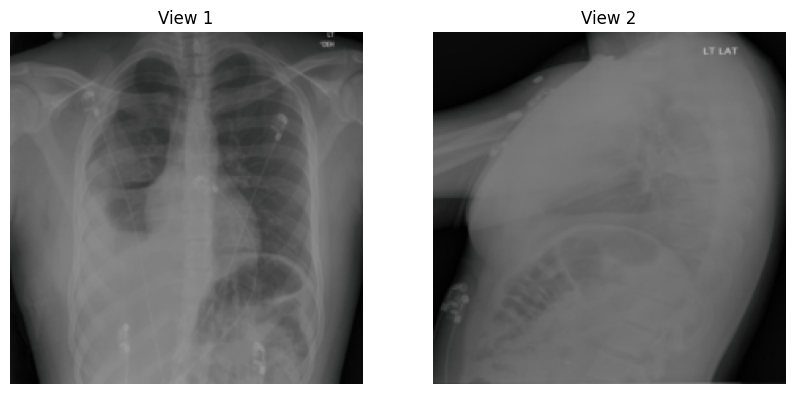


--- Ground Truth Report ---
mediastinal contours are normal. no significant change in pneumothorax or right pleural fluid..  no significant change in right pneumothorax or pleural fluid.

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


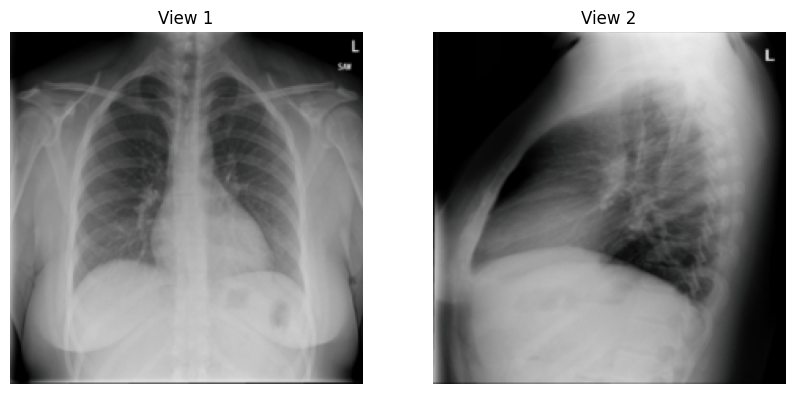


--- Ground Truth Report ---
the trachea is midline. the cardiomediastinal silhouette is normal and unchanged compared to prior examination. lungs are clear, without evidence of acute infiltrate or effusion. there is no pneumothorax. the visualized bony structures reveal no acute abnormalities.  no acute cardiopulmonary abnormalities.

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


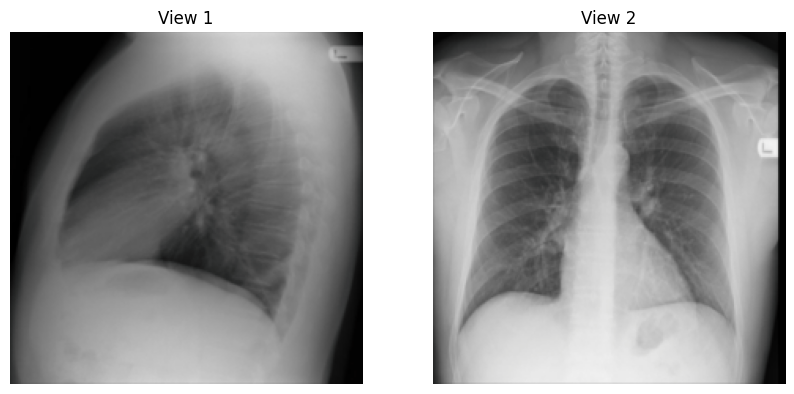


--- Ground Truth Report ---
the lungs are clear. the heart and pulmonary are normal. the pleural spaces are clear. mediastinal contours are normal.  no acute cardiopulmonary disease

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


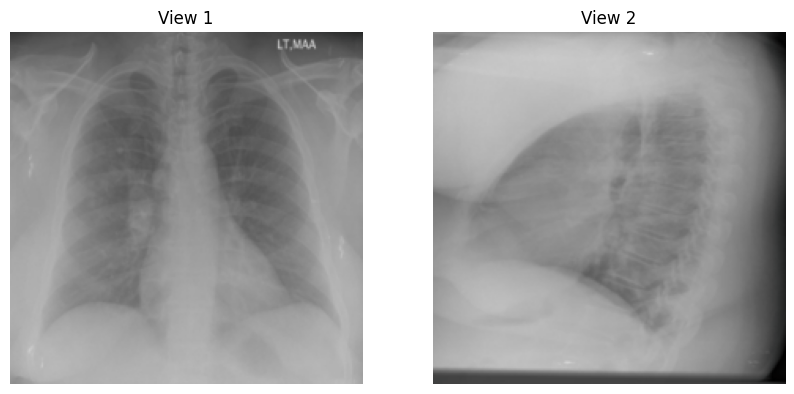


--- Ground Truth Report ---
sequelae of old granulomatous disease. vague patchy opacity in the right midlung which may represent early pneumonia. no pleural effusions or pneumothoraces. heart and mediastinum of normal size and contour. degenerative changes in the spine.  vague patchy opacity in the right midlung which may represent an early pneumonia given patient's history.

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


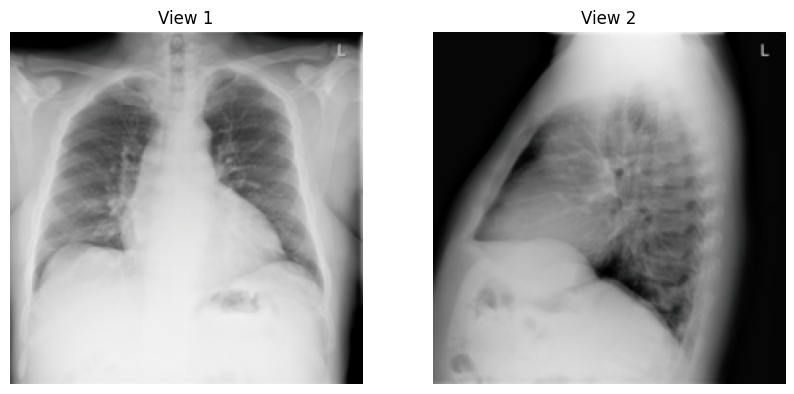


--- Ground Truth Report ---
cardiomegaly is present. the upper lobe pulmonary vascularity appears mildly prominent consistent with pulmonary venous hypertension. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. there is eventration of the right hemidiaphragm. bony changes of renal osteodystrophy are noted.  1. cardiomegaly and mild vascular prominence. 2. no evidence of acute disease.

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


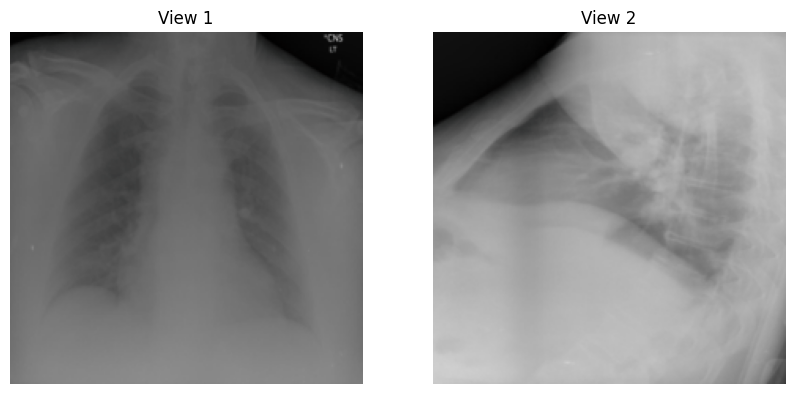


--- Ground Truth Report ---
the heart is enlarged. the mediastinum is unremarkable. atherosclerotic calcifications present within the thoracic aorta. there is no pleural effusion, pneumothorax, or focal airspace disease. chronic degenerative changes are noted within the spine.  1. cardiomegaly without acute cardiopulmonary abnormality.

--- Generated Report ---
Findings: the cardiomediastinal silhouette is normal in size and contour. no focal consolidation, pneumothorax or large pleural effusion. negative for acute displaced rib fracture.
Impression: negative for acute abnormality.
--------------------------------------------------------------------------------


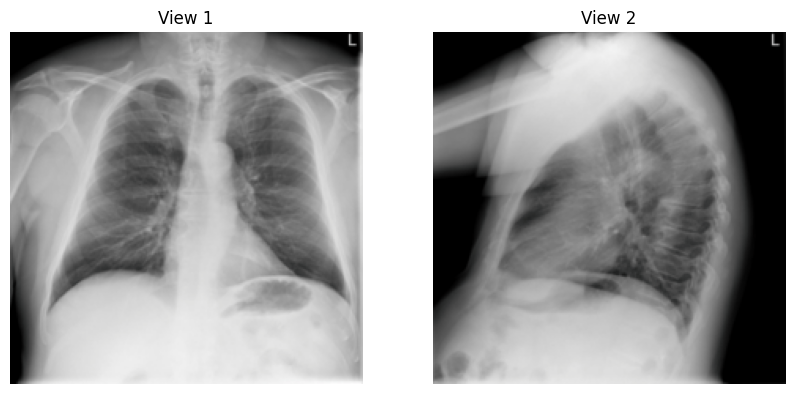


--- Ground Truth Report ---
heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. degenerative changes are present in the spine.  1. no evidence of active disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


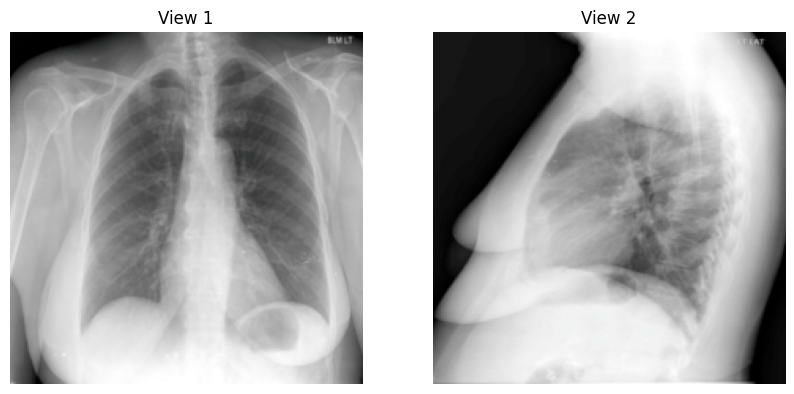


--- Ground Truth Report ---
the heart size and mediastinal contours appear within normal limits. no focal airspace consolidation, pleural effusions or pneumothorax. surgical clips overlying the left breast soft tissues. multilevel degenerative changes of the thoracic spine. no acute bony abnormalities.  no acute cardiopulmonary findings.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


In [88]:
evaluate_on_val_samples(trainer, train_loader, tokenizer, num_samples=20)

In [ ]:
trainer.plot_loss_and_perplexity()

In [51]:
sample_batch = next(iter(train_loader))
import torch

# Assume sample_batch is obtained from your train_loader like this:
# sample_batch = next(iter(train_loader))

# Move batch elements to device
images = sample_batch['images'].to(train_config.device)
input_ids = sample_batch['input_ids'].to(train_config.device)
attention_mask = sample_batch['attention_mask'].to(train_config.device)
labels = sample_batch['labels'].to(train_config.device)
view_mask = sample_batch.get('view_mask', None)
if view_mask is not None:
    view_mask = view_mask.to(train_config.device)

B, max_views, C, H, W = images.shape

# 1. Vision Encoder
print("Step 1: Vision Encoder")
images_flat = images.view(B * max_views, C, H, W)
pooled_feats_flat, _ = vl_model.vision_encoder(images_flat)
print(f"  pooled_feats_flat shape: {pooled_feats_flat.shape}  (Expected: [{B * max_views}, vision_dim])")

# Reshape back to (B, max_views, vision_dim)
vision_dim = pooled_feats_flat.shape[-1]
pooled_feats = pooled_feats_flat.view(B, max_views, vision_dim)
print(f"  pooled_feats reshaped: {pooled_feats.shape}  (Expected: [{B}, {max_views}, vision_dim])")

# 2. Fusion Module
print("\nStep 2: Fusion Module")
fused_feats = vl_model.fusion_module(pooled_feats, view_mask=view_mask)
print(f"  fused_feats shape: {fused_feats.shape}  (Expected: [{B}, vision_dim])")

# 3. Projection Layer
print("\nStep 3: Projection Layer")
projected_feats = vl_model.proj_layer(fused_feats)
print(f"  projected_feats shape: {projected_feats.shape}  (Expected: [{B}, gpt2_emb_dim])")

visual_emb = projected_feats.unsqueeze(1)
print(f"  visual_emb shape (unsqueezed): {visual_emb.shape}  (Expected: [{B}, 1, gpt2_emb_dim])")

# 4. GPT-2 Decoder Forward
print("\nStep 4: GPT-2 Decoder Forward")
outputs = vl_model.gpt2(
    input_ids=input_ids,
    attention_mask=attention_mask,
    encoder_hidden_states=visual_emb,
    labels=labels
)
print(f"  logits shape: {outputs.logits.shape}  (Expected: [{B}, seq_len, vocab_size])")
print(f"  loss: {outputs.loss.item()}")

# Optional: decode a sample generated output token sequence for quick qualitative check
predicted_ids = torch.argmax(outputs.logits, dim=-1)
sample_pred_ids = predicted_ids[0].cpu()
decoded_pred = tokenizer.decode(sample_pred_ids, skip_special_tokens=True)
print("\nSample decoded output from GPT-2 logits:")
print(decoded_pred)

# 5. Full VisionLanguageWrapper Forward (Optional check)
print("\nFull VisionLanguageWrapper Forward Pass")
full_outputs = vl_model(
    images=images,
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    view_mask=view_mask
)
print(f"  Full model logits shape: {full_outputs.logits.shape}")
print(f"  Full model loss: {full_outputs.loss.item()}")



You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step 1: Vision Encoder
  pooled_feats_flat shape: torch.Size([16, 640])  (Expected: [16, vision_dim])
  pooled_feats reshaped: torch.Size([8, 2, 640])  (Expected: [8, 2, vision_dim])

Step 2: Fusion Module
  fused_feats shape: torch.Size([8, 640])  (Expected: [8, vision_dim])

Step 3: Projection Layer
  projected_feats shape: torch.Size([8, 768])  (Expected: [8, gpt2_emb_dim])
  visual_emb shape (unsqueezed): torch.Size([8, 1, 768])  (Expected: [8, 1, gpt2_emb_dim])

Step 4: GPT-2 Decoder Forward
  logits shape: torch.Size([8, 124, 50259])  (Expected: [8, seq_len, vocab_size])
  loss: 10.924627304077148

Sample decoded output from GPT-2 logits:
 Kidwu stolen enhancescolour astonished amphib Regardless Breaking Atlstruction amateur charges Cookiesyre^^^^ log UCSDO steroids Leedsgininatory empiricalqq Wildernessrollment gods Gott Divide OUR 444 platforms understatement Chamberlainreshold Morse 336 unconsciouslypnFif454ickey fiCTV sacr Game Louis granted Madrid attracted Both abroad funct